## Application on Grid world

In [28]:
from markov import MDP
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

#Define GRID world
GRID_SIZE = 4
NUM_STATES = GRID_SIZE*GRID_SIZE
GAMMA = 1
S_ = [str(i) for i in range(NUM_STATES)]
A = ["N","E","S","w"]
N,E,S,W = 0,1,2,3
NUM_ACTIONS = len(A)
POLICY = np.full((NUM_ACTIONS,NUM_STATES),0.25)

R = {(s,a):-1 for s,a in product(S_,A)}
R.update({('0',a):0 for a in A})
R.update({('15',a):0 for a in A})

# Helper functions for clarity
def get_row(s): return s // GRID_SIZE
def get_col(s): return s % GRID_SIZE
def get_state(row, col): return row * GRID_SIZE + col

# Define movement rules for each direction
moves = {
    N: lambda s: get_state(get_row(s) - 1, get_col(s)) if get_row(s) > 0 else s,
    S: lambda s: get_state(get_row(s) + 1, get_col(s)) if get_row(s) < GRID_SIZE - 1 else s,
    E: lambda s: get_state(get_row(s), get_col(s) + 1) if get_col(s) < GRID_SIZE - 1 else s,
    W: lambda s: get_state(get_row(s), get_col(s) - 1) if get_col(s) > 0 else s
}

def fill_p(P):
    for s in range(1, NUM_STATES-1):  # Skip terminal states
        for direction in [N, S, E, W]:
            next_state = moves[direction](s)
            P[s, next_state, direction] = 1.0  # Probability 1 for intended direction
    
    # Terminal states
    P[0,0,:] = 1.0
    P[15,15,:] = 1.0
    return P

def fill_p_stochastic(P, success_prob=0.8):
    P = fill_p(P)  # Start with deterministic transitions
    for s in range(1, NUM_STATES-1):
        for direction in [N, S, E, W]:
            intended_next = moves[direction](s)
            # Add probability of failing to move
            P[s, intended_next, direction] = success_prob
            P[s, s, direction] = 1 - success_prob
    return P
            
P = np.zeros((NUM_STATES,NUM_STATES,NUM_ACTIONS))
P = fill_p(P)

#Set our MDP
mdp = MDP(S_,P,GAMMA,R,A)

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_q_matrix(Q, blocked_cells=None):
    """
    Plot a Q-matrix visualization for a 4x4 grid world.
    
    Parameters:
    Q : numpy array of shape (16, 4)
        Q-values for each state-action pair. The 4 columns represent [N,E,S,W]
    blocked_cells : list of int, optional
        List of cell indices (0-15) that are blocked/invalid
    """
    if blocked_cells is None:
        blocked_cells = []
        
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xlim(-0.1, 4.1)
    ax.set_ylim(-0.1, 4.1)
    
    # Turn off axis
    ax.set_xticks([])
    ax.set_yticks([])

    max_Q = Q.max()
    min_Q = Q.min()

    Q_norm = (Q-min_Q)/(max_Q-min_Q)
    
    # For each cell in the 4x4 grid
    for i in range(16):
        row = 3 - (i // 4)  # Convert to matrix coordinates (inverted rows)
        col = i % 4
        
        # If cell is blocked, draw gray square
        if i in blocked_cells:
            ax.add_patch(patches.Rectangle((col, row), 1, 1, facecolor='gray'))
            continue
            
        # Get Q-values for this state
        q_values = Q[i]
        q_plot = Q_norm[i]
        
        # Create the four triangles for each direction
        # North triangle
        north_tri = plt.Polygon([(col, row+1), (col+1, row+1), (col+0.5, row+0.5)], 
                              facecolor='white', edgecolor='black')
        # East triangle
        east_tri = plt.Polygon([(col+1, row+1), (col+1, row), (col+0.5, row+0.5)],
                              facecolor='white', edgecolor='black')
        # South triangle
        south_tri = plt.Polygon([(col+1, row), (col, row), (col+0.5, row+0.5)],
                               facecolor='white', edgecolor='black')
        # West triangle
        west_tri = plt.Polygon([(col, row), (col, row+1), (col+0.5, row+0.5)],
                              facecolor='white', edgecolor='black')
        
        for d in range(4):
            tri = [north_tri, east_tri, south_tri, west_tri][d]
            tri.set_facecolor(('green',q_plot[d]))
            
        # Add all triangles to plot
        for tri in [north_tri, east_tri, south_tri, west_tri]:
            ax.add_patch(tri)
            
        # Add Q-values as text
        ax.text(col+0.5, row+0.75, f'{q_values[0]:.2f}', ha='center', va='center')  # North
        ax.text(col+0.75, row+0.5, f'{q_values[1]:.2f}', ha='center', va='center')  # East
        ax.text(col+0.5, row+0.25, f'{q_values[2]:.2f}', ha='center', va='center')  # South
        ax.text(col+0.25, row+0.5, f'{q_values[3]:.2f}', ha='center', va='center')  # West
        
    plt.grid(True)
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def min_max(V):
    min_v = V.min()
    max_v = V.max()
    return (V-min_v)/(max_v-min_v)

def plot_v(data):
    x,y = data.shape

    data = min_max(data)

    # Plot the matrix with a colormap ranging from red to green
    plt.imshow(data, cmap='RdYlGn', vmin=0, vmax=1)

    # Add a colorbar to show the mapping between values and colors
    plt.colorbar(label='Value')

    # Add gridlines for better readability
    plt.xticks(np.arange(x), labels=[f'Col {i}' for i in range(4)])
    plt.yticks(np.arange(y), labels=[f'Row {i}' for i in range(4)])

    # Annotate each cell with its value
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, f'{data[i, j]:.2f}', 
                    ha='center', va='center', color='black')

    # Display the plot
    plt.show()


In [60]:
Q = mdp.state_va_function_vector(T_max=50,policy=POLICY,func="Q")
V = mdp.state_va_function_vector(T_max=50,policy=POLICY,func="V")

In [61]:
min_max(V)

array([1.  , 0.36, 0.09, 0.  , 0.36, 0.18, 0.09, 0.09, 0.09, 0.09, 0.18,
       0.36, 0.  , 0.09, 0.36, 1.  ])

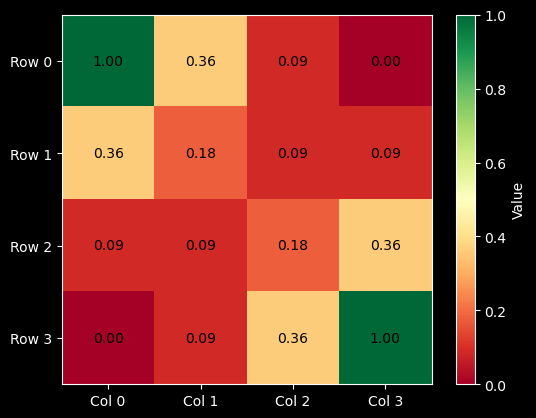

In [62]:
plot_v(V.reshape(4,4))

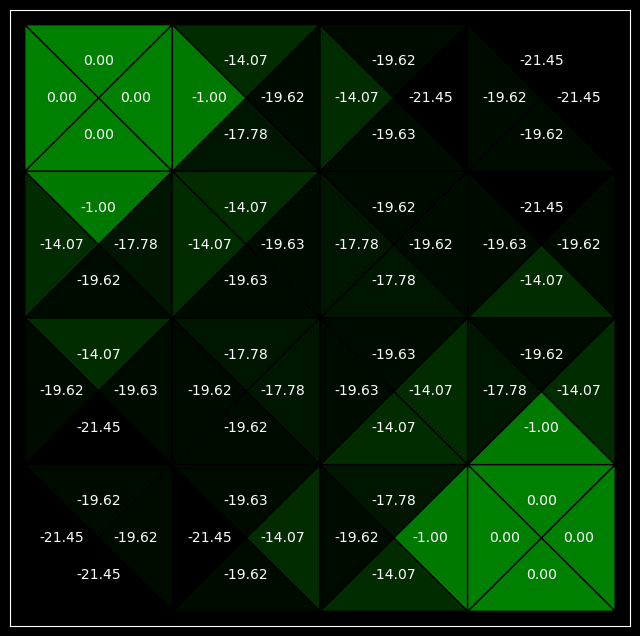

In [31]:
plot_q_matrix(Q)